In [1]:
#!/usr/bin/env julia

#   ======================   #
#%% CALCULATION PARAMETERS %%#
#   ======================   #   

orbital = "Butterfly3"
norbitals = 5

# construction and diagonalization in a single step
onestep = true
# use precomputed spin-CG coefficients
spinarray = true
# parallel computation
distributed = parallel = false
# parallel method: distfor or async
method = "distfor"
# discretization ("standard" or "co2005")
discretization = "co2005"

# clean system or with impurity added
calculation = "IMP"

# twisting parameter
z = 0.0

# numerical parameters
L = 2.5
betabar = 1.0

# cutoff
cutoff_type = "multiplet" 
cutoff_magnitude = 100
minmult = 0

# hamiltonian parameters
E_0  = 0.0
E_1  = 0.025
E_0p = 0.287
E_1p = 0.291
E_0n = 0.12 
E_1n = 0.122
#gam = 0.0
gam = 0.2


# command-line input
if length(ARGS)>0
    # clean/imp
    calculation = "IMP"
    if ARGS[1]=="CLEAN" 
        calculation = "CLEAN"
    end
    # twisting parameter
    if length(ARGS)>1
        z = parse(Float64,ARGS[2])
    end
    # relative parameters
    if length(ARGS)>2
        u_11_r = parse(Float64,ARGS[3])
        u_h_r  = parse(Float64,ARGS[4]) 
        gam_r  = parse(Float64,ARGS[5])
    end
end

iterations = 30

max_spin2 = 8

distworkers = 6

println( "====================" )
println( "SETUP AND PARAMETERS" )
println( "====================" )
@show calculation
@show distributed 
distributed && @show distworkers
@show method
@show discretization
@show z
@show cutoff_type
@show cutoff_magnitude
@show iterations
@show max_spin2
@show betabar
@show L
@show E_0
@show E_1 
@show E_0p
@show E_1p
@show E_0n
@show E_1n
@show gam  
println()


#   =======================   #
#%% MODULES AND DISTRIBUTED %%#
#   =======================   #

using DelimitedFiles
using ProfileVega
using Profile

include( "modules/symbols.jl" )
include( "modules/numericals.jl" )
include( "modules/compoundoperators.jl" )
include( "modules/shell.jl" )
include( "modules/thermo.jl" )
include( "modules/diagonalization.jl" )
include( "modules/spectral.jl" )
include( "modules/reddiag.jl" ) 
include( "modules/automatization.jl" )

if parallel 

    using Distributed 

    #1 kill current processes
    for i in workers()
        t = rmprocs(i, waitfor=0)
        wait(t)
    end

    # add requested workers
    if distworkers ≥ nprocs()
        addprocs(distworkers)
    else 
        println( "more workers than processors!" )
    end

    println( "DISTRIBUTED CALCULATION WITH $(nworkers()) WORKERS" )

    @everywhere begin 
        using ProgressMeter
        using PartialWaveFunctions
        using StaticArrays
        include( "modules/symmetry.jl" )
        include( "modules/diagonalization.jl" )
    end

else 

    println( "SERIAL CALCULATION" )

    using ProgressMeter
    using PartialWaveFunctions
    using StaticArrays

    include( "modules/symmetry.jl" )
    include( "modules/diagonalization.jl" )

end
println()

SETUP AND PARAMETERS
calculation = "IMP"
distributed = false
method = "distfor"
discretization = "co2005"
z = 0.0
cutoff_type = "multiplet"
cutoff_magnitude = 100
iterations = 30
max_spin2 = 8
betabar = 1.0
L = 2.5
E_0 = 0.0
E_1 = 0.025
E_0p = 0.287
E_1p = 0.291
E_0n = 0.12
E_1n = 0.122
gam = 0.2

SERIAL CALCULATION



In [2]:
#   ==============   #
#%% CLEBSCH-GORDAN %%#
#   ==============   #

CG_PATH = "/home/aitor/Bulegoa/ClebschGordan/Oh/cg_symbolic/"
ASYM_PATH = "/home/aitor/Bulegoa/AntiSymmetricPart/Oh/";

print( "Obtaining Clebsch-Gordan coefficients... " )
@time begin 
(oirreps,
 oirreps2indices,
 oirreps2dimensions,
 oindex2dimensions,
 cg_o_fullmatint) = get_cg_o_info( CG_PATH , ("A1g",)  )
cg_s_fullmatint = get_cg_s_fullmatint( max_spin2 );
end; println()

Obtaining Clebsch-Gordan coefficients... 
  0.152784 seconds (413.58 k allocations: 27.532 MiB, 98.27% compilation time)



In [3]:
# ==================== #
# ATOMIC HILBERT SPACE #
# ==================== #

#   --------------------- #
#%% atomic symstate basis #
#   --------------------- #
print( "Combining atomic multiplets... " )
@time begin
identityrep = "A1g"
hiztegia = Dict( 
    "o1" => "A1g",
    "o2" => "A1g",
    "o3" => "A1g",
    "o4" => "A1g",
    "o5" => "A1g",
    "u" =>  0.5 ,
    "d" => -0.5
)

# orbital 1
o1 = (0,"o1")                                                                       
o1_up = ( o1... , 1 , "u" )                                                             
o1_do = ( o1... , 1 , "d" )                                                             
hilbert_o1 = HilbertSpace([ o1_up , o1_do ])
symstates_o1_nor = oneirrep_symstates( 
                    hilbert_o1 , 
                    hiztegia ,
                    identityrep ,
                    "$(ASYM_PATH)$(identityrep)_julia/" ) 
symstates_o1 = Dict( (q[1:5]...,1)=>s 
                    for (q,s) in symstates_o1_nor )
# orbital 2 (b)
o2 = (0,"o2")                                                                        
o2_up = ( o2... , 1 , "u" )                                                             
o2_do = ( o2... , 1 , "d" )                                                             
hilbert_o2 = HilbertSpace([ o2_up , o2_do ])
symstates_o2_nor = oneirrep_symstates( 
                    hilbert_o2 , 
                    hiztegia ,
                    identityrep ,
                    "$(ASYM_PATH)$(identityrep)_julia/" ) 
symstates_o2 = Dict( (q[1:5]...,2)=>s 
                    for (q,s) in symstates_o2_nor )
# orbital 3 (c)
o3 = (0,"o3")                                                                       
o3_up = ( o3... , 1 , "u" )                                                             
o3_do = ( o3... , 1 , "d" )                                                             
hilbert_o3 = HilbertSpace([ o3_up , o3_do ])
symstates_o3_nor = oneirrep_symstates( 
                    hilbert_o3 , 
                    hiztegia ,
                    identityrep ,
                    "$(ASYM_PATH)$(identityrep)_julia/" ) 
symstates_o3 = Dict( (q[1:5]...,3)=>s 
                    for (q,s) in symstates_o3_nor )
# orbital 4 (c)
o4 = (0,"o4")                                                                       
o4_up = ( o4... , 1 , "u" )                                                             
o4_do = ( o4... , 1 , "d" )                                                             
hilbert_o4 = HilbertSpace([ o4_up , o4_do ])
symstates_o4_nor = oneirrep_symstates( 
                    hilbert_o4 , 
                    hiztegia ,
                    identityrep ,
                    "$(ASYM_PATH)$(identityrep)_julia/" ) 
symstates_o4 = Dict( (q[1:5]...,4)=>s 
                    for (q,s) in symstates_o4_nor )
# orbital 5 (c)
o5 = (0,"o5")                                                                       
o5_up = ( o5... , 1 , "u" )                                                             
o5_do = ( o5... , 1 , "d" )                                                             
hilbert_o5 = HilbertSpace([ o5_up , o5_do ])
symstates_o5_nor = oneirrep_symstates( 
                    hilbert_o5 , 
                    hiztegia ,
                    identityrep ,
                    "$(ASYM_PATH)$(identityrep)_julia/" ) 
symstates_o5 = Dict( (q[1:5]...,5)=>s 
                    for (q,s) in symstates_o5_nor )

# mix 
symstates_12   = cg_reduce_product_states( symstates_o1 ,
                                           symstates_o2 ,
                                           CG_PATH )
symstates_123  = cg_reduce_product_states( symstates_12 ,
                                           symstates_o3  ,
                                           CG_PATH )
symstates_1234 = cg_reduce_product_states( symstates_123 ,
                                           symstates_o4  ,
                                           CG_PATH )
symstates_0    = cg_reduce_product_states( symstates_1234 ,
                                           symstates_o5  ,
                                           CG_PATH )

# basis 
basis_0 = collect(values(symstates_0))[1].basis 

# multiplets 
multiplets_0 = get_multiplets( symstates_0 )
end; println() #timing 

Combining atomic multiplets...   6.790707 seconds (51.85 M allocations: 2.334 GiB, 9.15% gc time, 60.87% compilation time)



In [4]:
##   ------------------ #
##%% SELECTED SYMSTATES #
##   ------------------ #

@time begin

# atomic symstates
symstates_atom = Dict{Tuple{Int64,String,Float64,Int64,Float64,Int64},State}()

# creation operators 
cre_1u = Operator( SymbolCreationOperator(o1_up) , basis_0 )
cre_1d = Operator( SymbolCreationOperator(o1_do) , basis_0 )
cre_2u = Operator( SymbolCreationOperator(o2_up) , basis_0 )
cre_2d = Operator( SymbolCreationOperator(o2_do) , basis_0 )
cre_3u = Operator( SymbolCreationOperator(o3_up) , basis_0 )
cre_3d = Operator( SymbolCreationOperator(o3_do) , basis_0 )
cre_4u = Operator( SymbolCreationOperator(o4_up) , basis_0 )
cre_4d = Operator( SymbolCreationOperator(o4_do) , basis_0 )
cre_5u = Operator( SymbolCreationOperator(o5_up) , basis_0 )
cre_5d = Operator( SymbolCreationOperator(o5_do) , basis_0 )

# vacuum (seed) states
vac = State( basis_0.states[1] , basis_0 )

# MAYBE IT IS MORE CORRECT TO REMOVE NORMALIZATIONS

# CHECK THIS MULTIPLET: it does not seem to be an S=1 partner
# 0 multiplet: spin-1/2 doublet 
i_0 = (5,"A1g",0.5) 
m_0 = (5,"A1g",0.5,1)
# m=1/2
slat_22u00 = cre_1u*cre_1d*cre_2u*cre_2d*cre_3u*vac
slat_20u20 = cre_1u*cre_1d*cre_3u*cre_4u*cre_4d*vac
slat_2udu0 = cre_1u*cre_1d*cre_2u*cre_3d*cre_4u*vac 
slat_2uud0 = cre_1u*cre_1d*cre_2u*cre_3u*cre_4d*vac
s_0_p05 = 0.70*slat_22u00 +
          0.47*slat_20u20 +
          0.38*slat_2udu0 +
          0.21*slat_2uud0
normalize!( s_0_p05 )
# m=-1/2
slat_22d00 = cre_1u*cre_1d*cre_2u*cre_2d*cre_3d*vac 
slat_20d20 = cre_1u*cre_1d*cre_3d*cre_4u*cre_4d*vac 
slat_2dud0 = cre_1u*cre_1d*cre_2d*cre_3u*cre_4d*vac 
slat_2ddu0 = cre_1u*cre_1d*cre_2d*cre_3d*cre_4u*vac
s_0_m05 = 0.70*slat_22d00 +
          0.47*slat_20d20 +
          0.38*slat_2dud0 +
          0.21*slat_2ddu0 
normalize!( s_0_m05 )
# symstates 
symstates_m0 = Dict{Tuple{Int64,String,Float64,Int64,Float64,Int64},State}( 
                (i_0...,1, 0.5,1)=>s_0_p05 ,
                (i_0...,1,-0.5,1)=>s_0_m05 )
merge!( symstates_atom , symstates_m0 )

# 1 multiplet: spin-3/2 quadruplet
i_1 = (5,"A1g",1.5) 
m_1 = (5,"A1g",1.5,1)
# m=+3/2
slat_2uuu0 = cre_1u*cre_1d*cre_2u*cre_3u*cre_4u*vac
s_1_p15 = slat_2uuu0 
normalize!(s_1_p15)
# m=+1/2
slat_2uud0 = cre_1u*cre_1d*cre_2u*cre_3u*cre_4d*vac
slat_2udu0 = cre_1u*cre_1d*cre_2u*cre_3d*cre_4u*vac
slat_2duu0 = cre_1u*cre_1d*cre_2d*cre_3u*cre_4u*vac
s_1_p05 = ( sqrt(3.0)^-1 )*( slat_2uud0 + slat_2udu0 + slat_2duu0 )
normalize!( s_1_p05 )
# m=-1/2
slat_2ddu0 = cre_1u*cre_1d*cre_2d*cre_3d*cre_4u*vac
slat_2dud0 = cre_1u*cre_1d*cre_2d*cre_3u*cre_4d*vac
slat_2udd0 = cre_1u*cre_1d*cre_2u*cre_3d*cre_4d*vac
s_1_n05 = ( sqrt(3.0)^-1 )*( slat_2ddu0 + slat_2dud0 + slat_2udd0 ) 
normalize!( s_1_n05 )
# m=-3/2
slat_2ddd0 = cre_1u*cre_1d*cre_2d*cre_3d*cre_4d*vac
s_1_n15 = slat_2ddd0 
normalize!( s_1_n15 )
# symstates 
symstates_m1 = Dict{Tuple{Int64,String,Float64,Int64,Float64,Int64},State}( 
                (i_1...,1, 1.5,1)=>s_1_p15 ,
                (i_1...,1, 0.5,1)=>s_1_p05 ,
                (i_1...,1,-0.5,1)=>s_1_n05 ,
                (i_1...,1,-1.5,1)=>s_1_n15 )
merge!( symstates_atom , symstates_m1 )

# 0+ multiplet: spin-1 triplet
i_0p = (6,"A1g",1.0)::Tuple{Int64,String,Float64}
m_0p = (6,"A1g",1.0,1)::Tuple{Int64,String,Float64,Int64}
# m=0
slat_22ud0 = cre_1u*cre_1d*cre_2u*cre_2d*cre_3u*cre_4d*vac
slat_22du0 = cre_1u*cre_1d*cre_2u*cre_2d*cre_3d*cre_4u*vac
slat_2u2d0 = cre_1u*cre_1d*cre_2u*cre_3u*cre_3d*cre_4d*vac 
slat_2d2u0 = cre_1u*cre_1d*cre_2d*cre_3u*cre_3d*cre_4u*vac
slat_2udud = cre_1u*cre_1d*cre_2u*cre_3d*cre_4u*cre_5d*vac 
slat_2dudu = cre_1u*cre_1d*cre_2d*cre_3u*cre_4d*cre_5u*vac
s_0p_0 = 0.64*( slat_22ud0 + slat_22du0 ) +
         0.13*( slat_2u2d0 + slat_2d2u0 ) -
         0.14*( slat_2udud - slat_2dudu )
normalize!( s_0p_0 )
# m=+1
slat_22uu0 = cre_1u*cre_1d*cre_2u*cre_2d*cre_3u*cre_4u*vac 
slat_2u2u0 = cre_1u*cre_1d*cre_2u*cre_3u*cre_3d*cre_4u*vac 
slat_2uuud = cre_1u*cre_1d*cre_2u*cre_3u*cre_4u*cre_5d*vac 
slat_2uudu = cre_1u*cre_1d*cre_2u*cre_3u*cre_4d*cre_5u*vac
s_0p_p1 = sqrt(2.0)*0.64*slat_22uu0 +
          sqrt(2.0)*0.13*slat_2u2u0 -
          0.14*( slat_2uuud - slat_2uudu )
normalize!( s_0p_p1 )
# m=-1
slat_22dd0 = cre_1u*cre_1d*cre_2u*cre_2d*cre_3d*cre_3d*vac
slat_2d2d0 = cre_1u*cre_1d*cre_2d*cre_3u*cre_3d*cre_4d*vac 
slat_2ddud = cre_1u*cre_1d*cre_2d*cre_3d*cre_4u*cre_5d*vac
slat_2dddu = cre_1u*cre_1d*cre_2d*cre_3d*cre_4d*cre_5u*vac
s_0p_n1 = sqrt(2.0)*0.64*slat_22dd0 +
          sqrt(2.0)*0.13*slat_2d2d0 -
          0.14*( slat_2ddud - slat_2dddu ) 
normalize!( s_0p_n1 )
# symstates 
symstates_m0p = Dict{Tuple{Int64,String,Float64,Int64,Float64,Int64},State}( 
                    (i_0p...,1, 1.0,1)=>s_0p_p1 ,
                    (i_0p...,1, 0.0,1)=>s_0p_0 ,
                    (i_0p...,1,-1.0,1)=>s_0p_n1 )
merge!( symstates_atom , symstates_m0p ) 

# 1+ multiplet: spin-0 singlet 
i_1p = (6,"A1g",0.0) 
m_1p = (6,"A1g",0.0,1) 
# m=0
slat_22200 = cre_1u*cre_1d*cre_2u*cre_2d*cre_3u*cre_3d*vac 
slat_22020 = cre_1u*cre_1d*cre_2u*cre_2d*cre_4u*cre_4d*vac 
s_1p_0 = -0.72*slat_22200 +
          0.38*slat_22020 
normalize!( s_1p_0 )
# symstates 
symstates_m1p = Dict{Tuple{Int64,String,Float64,Int64,Float64,Int64},State}( 
                    (i_1p...,1,0.0,1)=>s_1p_0 ) 

# 0- multiplet: spin-1 triplet
i_0n = (4,"A1g",1.0) 
m_0n = (4,"A1g",1.0,1) 
# m=0
slat_2ud00 = cre_1u*cre_1d*cre_2u*cre_3d*vac 
slat_2du00 = cre_1u*cre_1d*cre_2d*cre_3u*vac 
s_0n_0 = ( sqrt(2.0)^-1 )*( slat_2ud00 + slat_2du00 ) 
normalize!( s_0n_0 ) 
# m=1 
slat_2uu00 = cre_1u*cre_1d*cre_2u*cre_3u*vac 
s_0n_p1 = slat_2uu00 
# m=-1
slat_2dd00 = cre_1u*cre_1d*cre_2d*cre_3d*vac
s_0n_n1 = slat_2dd00
# symstates
symstates_m0n = Dict{Tuple{Int64,String,Float64,Int64,Float64,Int64},State}( 
                    (i_0n...,1, 1.0,1)=>s_0n_p1 ,
                    (i_0n...,1, 0.0,1)=>s_0n_0 ,
                    (i_0n...,1,-1.0,1)=>s_0n_n1 )
merge!( symstates_atom , symstates_m0n )

# 1- multiplet: spin-0 singlet 
i_1n = (4,"A1g",0.0) 
m_1n = (4,"A1g",0.0,1) 
# m=0
slat_22000 = cre_1u*cre_1d*cre_2u*cre_2d*vac 
slat_20200 = cre_1u*cre_1d*cre_3u*cre_3d*vac 
slat_20020 = cre_1u*cre_1d*cre_4u*cre_4d*vac
s_1m_0 = 0.87*slat_22000 +
         0.32*slat_20200 + 
         0.30*slat_20020 
normalize!( s_1m_0 ) 
# symstates 
symstates_m1n = Dict{Tuple{Int64,String,Float64,Int64,Float64,Int64},State}( 
                    (i_1n...,1,0.0,1)=>s_1m_0 )
merge!( symstates_atom , symstates_m1n )


# atomic symstates and multiplets
multiplets_atom = Set([ m_0 , m_1 , m_0p , m_1p , m_0n , m_1n ])

end 


 30.782295 seconds (46.80 M allocations: 5.574 GiB, 1.38% gc time, 0.01% compilation time)


Set{Tuple{Int64, String, Float64, Int64}} with 6 elements:
  (5, "A1g", 1.5, 1)
  (5, "A1g", 0.5, 1)
  (4, "A1g", 1.0, 1)
  (6, "A1g", 1.0, 1)
  (4, "A1g", 0.0, 1)
  (6, "A1g", 0.0, 1)

In [5]:
##   =================== #
##&& INITIAL HAMILTONIAN #
##   =================== #

# parameter renormalization
if discretization=="standard"
    global α = 0.5 * L^z * (1+L^-1)
elseif discretization=="co2005"
    global α = compute_ebar0_z(z,L;discretization=discretization)
end
E_0  /= α
E_1  /= α
E_0p /= α 
E_1p /= α
E_0n /= α 
E_1n /= α 
gam  /= α


#   ----- #
#%% irreu #
#   ----- #
irrEU_clean = get_irrEU_clean( "A1g" )
irrEU_imp   = Dict{Tuple{Int64, String, Float64}, Tuple{Vector{Float64}, Matrix{ComplexF64}}}( 
                   i_0  => ([E_0], [ComplexF64(1.0)][:,:]) ,
                   i_1  => ([E_1], [ComplexF64(1.0)][:,:]) ,
                   i_0p => ([E_0p],[ComplexF64(1.0)][:,:]) ,
                   i_1p => ([E_1p],[ComplexF64(1.0)][:,:]) ,
                   i_0n => ([E_0n],[ComplexF64(1.0)][:,:]) ,
                   i_1n => ([E_1n],[ComplexF64(1.0)][:,:]) )
if calculation=="IMP" 
    multiplets_block = multiplets_atom 
    global irrEU = irrEU_imp
elseif calculation=="CLEAN" 
    multiplets_block = Set([ (0,"A1g",0.0,1) ])
    global irrEU = irrEU_clean
end


Dict{Tuple{Int64, String, Float64}, Tuple{Vector{Float64}, Matrix{ComplexF64}}} with 6 entries:
  (6, "A1g", 1.0) => ([0.438407], [1.0+0.0im])
  (5, "A1g", 0.5) => ([0.0], [1.0+0.0im])
  (4, "A1g", 0.0) => ([0.186361], [1.0+0.0im])
  (5, "A1g", 1.5) => ([0.0381888], [1.0+0.0im])
  (6, "A1g", 0.0) => ([0.444517], [1.0+0.0im])
  (4, "A1g", 1.0) => ([0.183306], [1.0+0.0im])

In [6]:
##   ================================================   #
##&& NUMERICAL ADDITION OF INNERMOST CONDUCTION SHELL &&#
##   ================================================   #

#   ---------------   #
#%% combinations u' %%#
#   ---------------   #
combinations_uprima = 
    Dict{ Tuple{Int64,Int64,Int64,Int64} , NTuple{2,Tuple{Int64,Int64,Int64,Int64}} }()
m_vac = (0,oirreps2indices["A1g"],0,1)
if calculation=="IMP"
    for m_mu in multiplets_atom
        mint_mu = convert_to_int( m_mu , oirreps2indices )
        push!( combinations_uprima , mint_mu=>(mint_mu,m_vac) )
    end 
elseif calculation=="CLEAN" 
    push!( combinations_uprima , m_vac=>(m_vac,m_vac) )
end

irreps_uprima = Set( k[1:3] for k in keys(combinations_uprima) )
combinations_uprima = 
        Dict{ NTuple{3,Int64} , Vector{NTuple{3,NTuple{4,Int64}}} }(
            G => NTuple{3,NTuple{4,Int64}}[
                (m_u,m_mu,m_i)
                for (m_u,(m_mu,m_i)) in combinations_uprima 
                if m_u[1:3]==G
                ]
            for G in irreps_uprima
        ) 
println( "COMBINATIONS U' FOR N=0" )
for (G,combs) in combinations_uprima
    println( "$G => $combs" )
end
println()

#   ---------------------------   #
#%% atom pseudo-CG coefficients %%#
#   ---------------------------   #

# hoppers
pcg_atom = Dict{NTuple{3,Tuple{Int64,String,Float64,Int64,Float64,Int64}},ComplexF64}()
#q_3up = (1,"A1g",0.5,1, 0.5,3)
#q_3do = (1,"A1g",0.5,1,-0.5,3)
q_3up = (1,"A1g",0.5,1, 0.5,1)
q_3do = (1,"A1g",0.5,1,-0.5,1)
qq_a  = [q_3up,q_3do] 
println( "ONE-PARTICLE HOPPERS" )
@show qq_a
println()

# pcg
for (q1,s1) in symstates_atom,
    (q2,s2) in symstates_atom

    cup = s1 * cre_3u * s2 
    cdo = s1 * cre_3d * s2

    isapprox(cup,0.0) || (pcg_atom[(q1,q_3up,q2)]=cup)
    isapprox(cdo,0.0) || (pcg_atom[(q1,q_3do,q2)]=cdo)

end
println( "======================" )
println( "PSEUDO-CG COEFFICIENTS" )
println( "======================" )
println( "ATOMIC PCG" )
print_dict( pcg_atom )
println()



#   ----------------------------------- #
#%% shell symstates, multiplets and pcg #
#   ----------------------------------- #

# symstates
s_shell_0_0 = vac
s_shell_1_u = cre_3u*vac
s_shell_1_d = cre_3d*vac
s_shell_2_0 = cre_3u*cre_3d*vac
symstates_shell = Dict{Tuple{Int64,String,Float64,Int64,Float64,Int64},State}(
                    (0,"A1g",0.0,1, 0.0,1)=>s_shell_0_0 ,
                    (1,"A1g",0.5,1, 0.5,1)=>s_shell_1_u ,
                    (1,"A1g",0.5,1,-0.5,1)=>s_shell_1_d ,
                    (2,"A1g",0.0,1, 0.0,1)=>s_shell_2_0 
                   )
println( "***********************************************************************")
println( "SHELL SELECTED SYMSTATES" )
print_dict( symstates_shell )

# multiplets
multiplets_shell = Set( (q[1:3]...,q[end]) for q in keys(symstates_shell) )
irrmult_shell = get_irreps( multiplets_shell ; multiplicity=true )
println( "SHELL SELECTED MULTIPLETS" )
for m in multiplets_shell
    println( m )
end
println( "***********************************************************************")
println()

# pcg
pcg_shell = Dict{NTuple{3,Tuple{Int64,String,Float64,Int64,Float64,Int64}},ComplexF64}()
for (q1,s1) in symstates_shell,
    (q2,s2) in symstates_shell

    cup = s1 * cre_3u * s2 
    cdo = s1 * cre_3d * s2

    isapprox(cup,0.0) || (pcg_shell[(q1,q_3up,q2)]=cup)
    isapprox(cdo,0.0) || (pcg_shell[(q1,q_3do,q2)]=cdo)
end
println( "SHELL PCG" )
print_dict( pcg_shell )
println()


#   -----------------   #
#%% hopping parameter %%#
#   -----------------   #
hop = Dict( 
    #(oirreps2indices["A1g"],3) => ComplexF64(gam) 
    (oirreps2indices["A1g"],1) => ComplexF64(gam) 
)
println( "ATOM-SHELL HOPPING PARAMETER" )
@show hop
println()


#   ------------------------ #
##% conversion to int format #
#   ------------------------ #
multiplets_block = Set([ convert_to_int(m,oirreps2indices) 
                         for m in multiplets_block ])
multiplets_shell = Set([ convert_to_int(m,oirreps2indices) 
                         for m in multiplets_shell ])
irrEU = Dict( convert_to_int(G,oirreps2indices)=>x 
                         for (G,x) in irrEU )
qq_a = [ convert_to_int(q,oirreps2indices) 
                         for q in qq_a ]
pcg_atom  = Dict( (convert_to_int(k[1],oirreps2indices),
                   convert_to_int(k[2],oirreps2indices),
                   convert_to_int(k[3],oirreps2indices))=>v 
                 for (k,v) in pcg_atom )
pcg_shell = Dict( (convert_to_int(k[1],oirreps2indices),
                   convert_to_int(k[2],oirreps2indices),
                   convert_to_int(k[3],oirreps2indices))=>v 
                 for (k,v) in pcg_shell )

multiplets_a = Set( (q[1:3]...,q[6]) for q in qq_a )
pcgred_atom = get_redmat2(
                pcg_atom ,
                multiplets_block ,
                multiplets_a ,
                cg_o_fullmatint ,
                cg_s_fullmatint ;
                verbose=true )
pcgred_shell = get_redmat2( 
                pcg_shell ,
                multiplets_shell ,
                multiplets_a ,
                cg_o_fullmatint ,
                cg_s_fullmatint )
println( "PCGRED ATOM" ) 
print_dict( pcgred_atom )
println( "PCGRED SHELL" ) 
print_dict( pcgred_shell )

#   -----------------   #
#%% excitation matrix %%#
#   -----------------   #
atom_creops = Dict(
    (1,"A1g",0.5,1, 0.5,1) => cre_2u,
    (1,"A1g",0.5,1,-0.5,1) => cre_2d,
    (1,"A1g",0.5,1, 0.5,2) => cre_1u, 
    (1,"A1g",0.5,1,-0.5,2) => cre_1d,
    (1,"A1g",0.5,1, 0.5,3) => cre_3u,
    (1,"A1g",0.5,1,-0.5,3) => cre_3d,
    (1,"A1g",0.5,1, 0.5,4) => cre_4u,
    (1,"A1g",0.5,1,-0.5,4) => cre_4d,
    (1,"A1g",0.5,1, 0.5,5) => cre_5u,
    (1,"A1g",0.5,1,-0.5,5) => cre_5d)

pcg_atom_full = Dict()
for (qbra,sbra) in symstates_atom,
    (qket,sket) in symstates_atom,
    (qa,oa)     in atom_creops 

    c = sbra*oa*sket 
    if !isapprox( abs2(c) , 0.0 )
        pcg_atom_full[(qbra,qa,qket)] = c 
    end

end
println( "PCG ATOM FULL" )
print_dict( pcg_atom_full ) 
println()
pcg_atom_full = Dict( 
    (convert_to_int(k[1],oirreps2indices),
     convert_to_int(k[2],oirreps2indices),
     convert_to_int(k[3],oirreps2indices))=>v
     for (k,v) in pcg_atom_full )
#multiplets_a = Set((q[1:3]...,q[6]) for (s1,q,s2) in keys(pcg_atom_full))
multiplets_atomhop = Set((convert_to_int(q,oirreps2indices)[1:3]...,q[6]) 
                   for q in keys(atom_creops))
Mred, AA = setup_redmat_AA(
            pcg_atom_full ,
            multiplets_block ,
            collect(multiplets_atomhop) ,
            cg_o_fullmatint ,
            cg_s_fullmatint ,
            irrEU ;
            verbose=true )


#   ------------------- #
#%% impurity multiplets #
#   ------------------- #
println("IMPURITY MULTIPLET SPACE")
omults = ordered_multiplets(multiplets_block)
mult2index = Dict( m=>i for (i,m) in 
                   enumerate(omults))
mm_i = Dict( 
            m=>[(i==mult2index[m] ? 1.0 : 0.0)
                for i in 1:length(multiplets_block)] 
                for m in omults
           )
@show mm_i 
m_imp = mult_thermo( irrEU ,
                     betabar ,
                     oindex2dimensions ,
                     mm_i )

#   -------------------   #
#%% clebsch-gordan sums %%#
#   -------------------   #
Bsum_o_dict,Bsum_s_dict,Csum_o_dict,Csum_s_dict =
    precompute_CGsums(
            oirreps ,
            multiplets_a,
            multiplets_block ,
            max_spin2 ,
            oindex2dimensions ,
            cg_o_fullmatint ,
            cg_s_fullmatint ;
            verbose=false )
Bsum_o_array,Bsum_s_array,Csum_o_array,Csum_s_array = 
    CGsums_dict2array( Bsum_o_dict,
                       Bsum_s_dict,
                       Csum_o_dict,
                       Csum_s_dict ) 

(Karray_orbital,Karray_spin) = compute_Ksum_arrays(
            oindex2dimensions,
            cg_o_fullmatint,
            cg_s_fullmatint,
            1 ,
            [1] ,
            max_spin2 ,
            1 )


#   --------------------------------------- #
#%% diagonalization: atom + innermost shell #
#   --------------------------------------- #
#println( "irrEU before adding the innermost shell" )
#print_dict( irrEU )
#println()
#if distributed
#    global (irrEU_old,combinations_uprima_old) = 
#                matdiag_distributed_dict(
#                            multiplets_block ,
#                            multiplets_shell ,
#                            irrEU ,
#                            hop ,
#                            cg_o_fullmatint ,
#                            cg_s_fullmatint ,
#                            pcg_atom ,
#                            pcg_shell ,
#                            qq_a ,
#                            combinations_uprima ,
#                            oindex2dimensions ;
#                            verbose=false )
#else 
#    global (irrEU_old,combinations_uprima_old) = 
#                matdiag_serial_dict(
#                            multiplets_block ,
#                            multiplets_shell ,
#                            irrEU ,
#                            hop ,
#                            cg_o_fullmatint ,
#                            cg_s_fullmatint ,
#                            pcg_atom ,
#                            pcg_shell ,
#                            qq_a ,
#                            combinations_uprima ,
#                            oindex2dimensions ;
#                            verbose=false )
#end
(irrEU,combinations_uprima) = matdiag_redmat(
                multiplets_block , 
                multiplets_shell ,
                irrEU , 
                hop , 
                cg_o_fullmatint , 
                cg_s_fullmatint ,
                Csum_o_array ,
                Csum_s_array ,
                Bsum_o_array ,
                Bsum_s_array ,
                pcgred_atom ,
                pcgred_shell ,
                collect(multiplets_a) , 
                combinations_uprima , 
                oindex2dimensions ;
                verbose=false ,
                distributed=distributed );
#println( "REFERENCE CALCULATION" )
#print_dict( irrEU_old )
#println( "THIS METHOD" )
#print_dict( irrEU )
#for (G,(E,U)) in irrEU 
#    Eo,Uo = irrEU_old[G]
#    if !all(E.≈Eo)
#        println( "UNEQUAL" )
#        @show sum(abs2.(E-Eo))
#    end
#end
#x=y
#minE = minimum(xk[e for (E,U) in values(irrEU) for e in E])
#irrEU = Dict( G=>(E.-minE,U) for (G,(E,U)) in irrEU )
println( "irrEU after adding the innermost shell" )
print_dict( irrEU )
println()

# impurity thermodynamics 
mm_i,m_imp = update_impmultinfo( 
                mm_i ,
                irrEU ,
                betabar ,
                oindex2dimensions ,
                combinations_uprima )

#   ~~~~~~~~~~~~~~~~~~~   #
#%% transformation of M %%#
#   ~~~~~~~~~~~~~~~~~~~   #
Mred, AA = update_redmat_AA_CGsummethod(
            Mred ,
            irrEU ,
            combinations_uprima ,
            collect(multiplets_atomhop) ,
            cg_o_fullmatint ,
            cg_s_fullmatint ,
            Karray_orbital ,
            Karray_spin ,
            AA ;
            verbose=true )
println( "TRANSFORMED EXCITATION MATRIX" )
print_dict( Mred )
println()
println( "AA" )
print_dict( AA )

COMBINATIONS U' FOR N=0
(5, 1, 1) => [((5, 1, 1, 1), (5, 1, 1, 1), (0, 1, 0, 1))]
(4, 1, 0) => [((4, 1, 0, 1), (4, 1, 0, 1), (0, 1, 0, 1))]
(6, 1, 0) => [((6, 1, 0, 1), (6, 1, 0, 1), (0, 1, 0, 1))]
(5, 1, 3) => [((5, 1, 3, 1), (5, 1, 3, 1), (0, 1, 0, 1))]
(4, 1, 2) => [((4, 1, 2, 1), (4, 1, 2, 1), (0, 1, 0, 1))]
(6, 1, 2) => [((6, 1, 2, 1), (6, 1, 2, 1), (0, 1, 0, 1))]

ONE-PARTICLE HOPPERS
qq_a = [(1, "A1g", 0.5, 1, 0.5, 1), (1, "A1g", 0.5, 1, -0.5, 1)]

PSEUDO-CG COEFFICIENTS
ATOMIC PCG
((6, "A1g", 1.0, 1, -1.0, 1), (1, "A1g", 0.5, 1, -0.5, 1), (5, "A1g", 0.5, 1, -0.5, 1))
0.27264910416665894 + 0.0im

((6, "A1g", 1.0, 1, 0.0, 1), (1, "A1g", 0.5, 1, 0.5, 1), (5, "A1g", 1.5, 1, -0.5, 1))
-0.15892111782799176 + 0.0im

((6, "A1g", 1.0, 1, 1.0, 1), (1, "A1g", 0.5, 1, 0.5, 1), (5, "A1g", 1.5, 1, 0.5, 1))
-0.11237420008991929 + 0.0im

((6, "A1g", 1.0, 1, 1.0, 1), (1, "A1g", 0.5, 1, -0.5, 1), (5, "A1g", 1.5, 1, 1.5, 1))
0.19463782401565127 + 0.0im

((6, "A1g", 1.0, 1, 0.0, 1), (1, "A1g", 0.5

In [7]:
#   =============== #
#%% NRG CALCULATION #
#   =============== #

# hopchannels 
hopchannels = collect(keys( hop ))

# actual NRG
@time @profile nrg = NRG_pcgred( iterations,
                   cutoff_type,
                   cutoff_magnitude,
                   L,
                   hopchannels,
                   irrEU,
                   multiplets_shell,
                   cg_o_fullmatint,
                   cg_s_fullmatint,
                   Csum_o_array ,
                   Csum_s_array ,
                   Bsum_o_array ,
                   Bsum_s_array ,
                   pcgred_shell,
                   collect(multiplets_a), 
                   combinations_uprima,
                   betabar,
                   oindex2dimensions,
                   mm_i ;
                   distributed=distributed ,
                   method=method ,
                   z=z ,
                   discretization=discretization ,
                   verbose=false ,
                   spectral=true ,
                   M=Mred ,
                   AA=AA , 
                   etafac=1.0 ,
                   Karray_orbital=Karray_orbital ,
                   Karray_spin=Karray_spin ,
                   multiplets_atomhop=collect(multiplets_atomhop) );

NRG PROCEDURE

ITERATION n=2
Applying cutoff to obtain block multiplets...   0.000064 seconds (87 allocations: 19.180 KiB)
22 multiplets kept (56 states), 0 multiplets discarded
proportion: 100.0%. max energy: 0.7257173629925933.
Renormalizing eigenvalues...
shell hopping = 0.8008506274338702913200018666706472872187947986820876511958885901984377144744418
Diagonalizing Hamiltonian...
(ppp.time, ppp.bytes * 10 ^ -6, ppp.gctime) = (0.00073624, 0.8671920000000003, 0.0)
m_imp = [0.20611665851479274, 0.07434349138891053, 0.34615282000237657, 0.18950324124794313, 0.13842443147903916, 0.04545935736693779]
THERMODYNAMICS
t = 0.7
ρ = 44.67054936360196
entr = 3.7993144335557414
mag = 0.9222669902371011
N = 0.4784258248743558
en = 1.2697106259127706

Updating M and AA...   0.000875 seconds (1.78 k allocations: 645.867 KiB)
ITERATION n=3
Applying cutoff to obtain block multiplets...   0.000043 seconds (135 allocations: 109.336 KiB)
83 multiplets kept (224 states), 0 multiplets discarded
proportion:

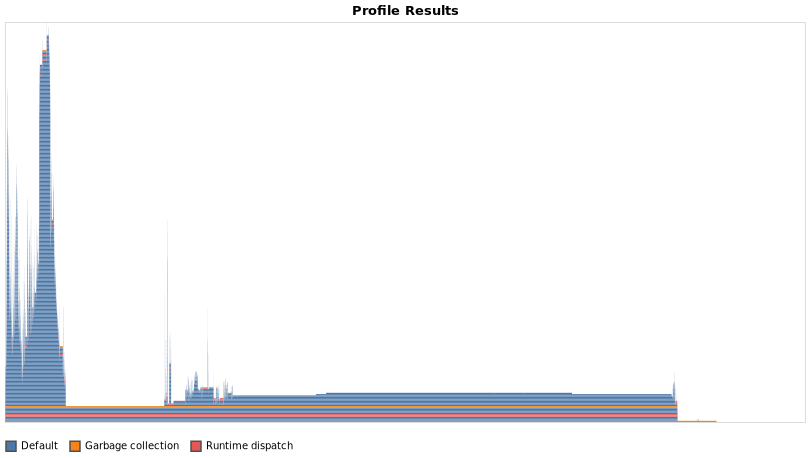

In [8]:
ProfileVega.view()
